# Natural Language Processing with Disaster Tweets

Kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started/overview

Predict which Tweets are about real disasters and which ones are not.

In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten,SimpleRNN
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,classification_report


# Data

Loading data files train.csv and test.csv. Files were downloaded from Kaggle

In [ ]:
training=pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")

# Exploratory Data Analysis

Displaying the training data specifications

In [53]:
training.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [54]:
training.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
training.shape

(7613, 5)

### Show the training data classification.

Seems like it's pretty balanced

(array([4342.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3271.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

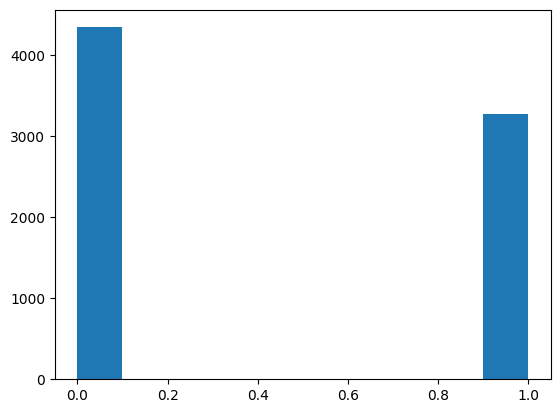

In [56]:
# Histogram on training data
plt.hist(training["target"])

In [57]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [58]:
test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [ ]:
test.shape

(3263, 4)

### Removing extra colums that we don't need

In [ ]:
train = training.drop(['id', 'keyword', 'location'], axis=1)
test = test.drop(['id', 'keyword', 'location'], axis=1)

### Split data

- 20% validation
- 80% training

In [61]:
# Splitting the data into training and validation data
from sklearn.model_selection import train_test_split
X = train["text"]
y = train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
X_test = test['text'].values.reshape(len(test),)

### Pre-process data

In [63]:
total_tweets = np.concatenate((X_train,X_val,X_test))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_tweets)

# Finding the vocabulary Size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary : ', vocab_size)

Vocabulary :  29320


In [64]:
# Finding the maximum length of tweet
maxlen = max(len(x.split()) for x in total_tweets)
print('Maximum length of tweet : ', maxlen)

Maximum length of tweet :  31


### For consistency, converting strings to int sequences

In [65]:
#  Converting texts to sequences
X_train_token = tokenizer.texts_to_sequences(X_train)
X_val_token = tokenizer.texts_to_sequences(X_val)
X_test_token = tokenizer.texts_to_sequences(X_test)

### Data padding

In [67]:
# Padding the data to keep the length equal
X_train_pad = pad_sequences(X_train_token, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_token, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_token, maxlen=maxlen, padding='post')

# Model architecture

### SimpleRNN (Simple Recurrent Neural Network)


In [ ]:
model2 =Sequential([
    Embedding(input_dim=vocab_size,output_dim=32,input_length=maxlen),
    SimpleRNN(units=32, return_sequences = True),
    SimpleRNN(units=64),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(units=1,activation='sigmoid')
])

/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model2.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

We will use early stopping so that we do not ovefit the model using EarlyStopping from tensorflow.keras.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
mini_batch_size = 32
epochs = 10

early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

# Fitting the model
model2_history = model2.fit(X_train_pad, y_train, 
                          batch_size=mini_batch_size, 
                          epochs=epochs,validation_data=(X_val_pad,y_val)
                            ,callbacks=[early_stopping])


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6462 - loss: 0.6222 - val_accuracy: 0.7630 - val_loss: 0.5295
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8568 - loss: 0.3541 - val_accuracy: 0.7400 - val_loss: 0.5545
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9612 - loss: 0.1235 - val_accuracy: 0.7551 - val_loss: 0.7323
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9794 - loss: 0.0628 - val_accuracy: 0.7643 - val_loss: 0.7505


In [72]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 31, 32)         │       938,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 31, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,890,277 (11.03 MB)

 Trainable params: 963,425 (3.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,926,852 (7.35 MB)

In [73]:
# Generate predictions for the test data
pred = model2.predict(X_test_pad)

# Print the prediction scores
print("Prediction scores")
print(pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Prediction scores
[[0.16629219]
 [0.1645086 ]
 [0.8457968 ]
 ...
 [0.44343823]
 [0.5613697 ]
 [0.16552049]]


### Results

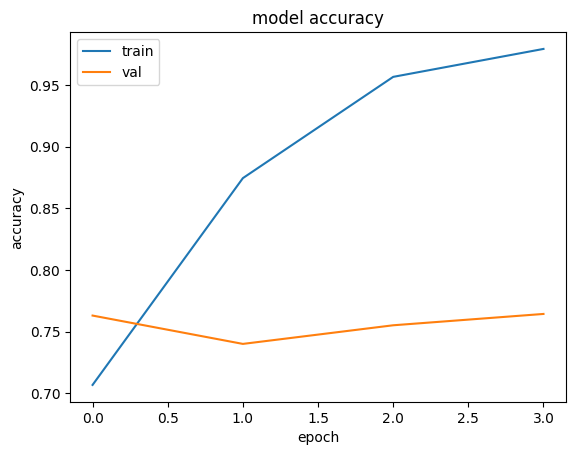

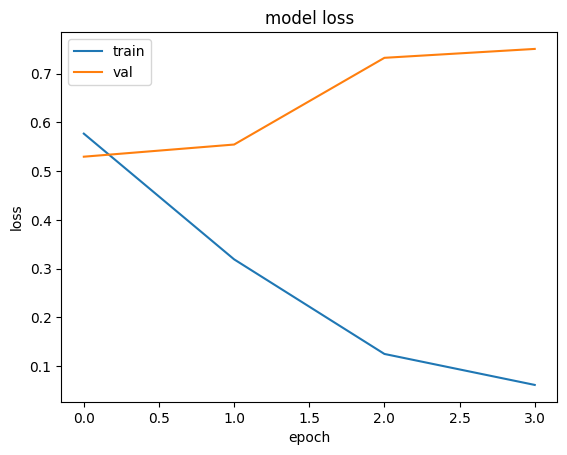

In [74]:
# Accuracy Plot
plt.plot(model2_history.history['accuracy'])
plt.plot(model2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss Plot
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


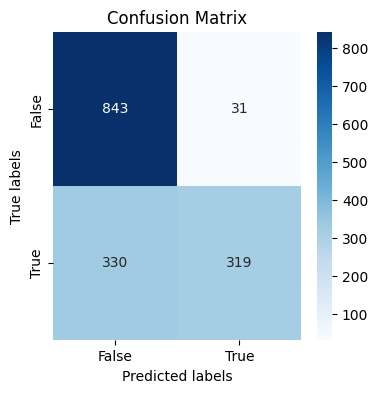

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes for validation data
y_pred = model2.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix using Seaborn
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")  # fmt='d' for integer format
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

# Display the plot
plt.show()

In [76]:
y_pred = model2.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Converting probabilities to binary predictions

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)  

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precision: 0.9114285714285715
Recall: 0.4915254237288136
F1 Score: 0.6386386386386387
ROC-AUC: 0.7280281580886631


In [77]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.96      0.82       874
           1       0.91      0.49      0.64       649

    accuracy                           0.76      1523
   macro avg       0.82      0.73      0.73      1523
weighted avg       0.80      0.76      0.74      1523



# LSTM Model (Long Short-Term Memory)


In [ ]:
hidden_units = 256
embed_units = 200

model = Sequential()
model.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [79]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [80]:
mini_batch_size = 32
epochs = 10
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Model Fitting
model_history = model.fit(X_train_pad, y_train, 
                          batch_size=mini_batch_size, 
                          epochs=epochs,validation_data=(X_val_pad,y_val)
                         ,callbacks=[early_stopping])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6760 - loss: 0.5933 - val_accuracy: 0.7997 - val_loss: 0.4598
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8988 - loss: 0.2622 - val_accuracy: 0.7925 - val_loss: 0.5035
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9622 - loss: 0.1075 - val_accuracy: 0.7492 - val_loss: 0.7098
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9887 - loss: 0.0378 - val_accuracy: 0.7374 - val_loss: 1.3065


In [81]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 31, 200)        │     5,864,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │       935,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,794,565 (79.32 MB)

 Trainable params: 6,931,521 (26.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,863,044 (52.88 MB)

In [82]:
# Generate predictions for the test data
pred = model.predict(X_test_pad)

# Print the prediction scores
print("Prediction scores:")
print(pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Prediction scores:
[[0.35937542]
 [0.69115436]
 [0.7082186 ]
 ...
 [0.8476954 ]
 [0.800223  ]
 [0.3123441 ]]


### LSTM Model Results

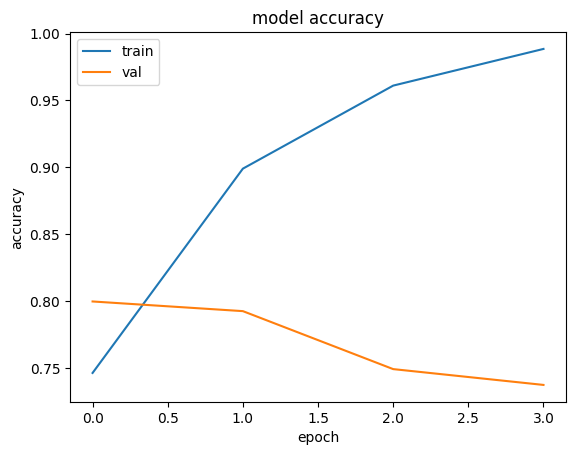

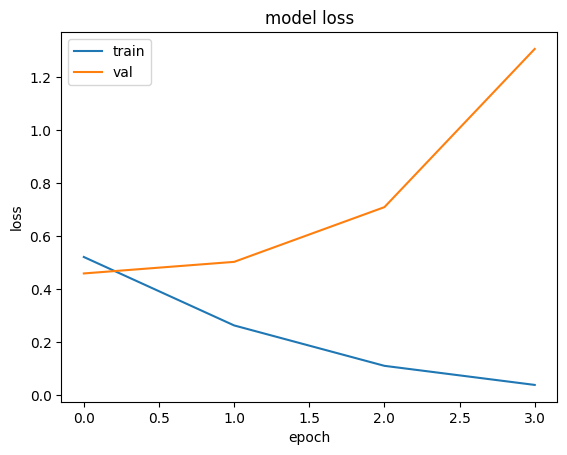

In [84]:
# Accuracy Plot
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss Plot
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


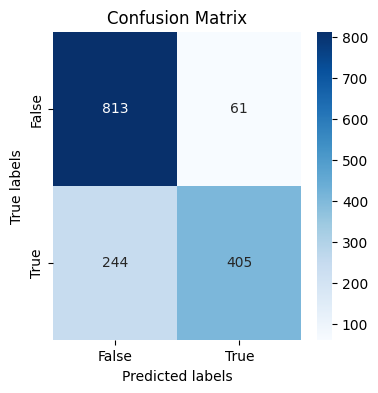

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes for validation data
y_pred = model.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix 
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")  # fmt='d' for integer format
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

# Display the plot
plt.show()

In [86]:
y_pred = model.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)  


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.869098712446352
Recall: 0.6240369799691834
F1 Score: 0.726457399103139
ROC-AUC: 0.777121464812967


In [87]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       874
           1       0.87      0.62      0.73       649

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523



# GRU(Gated Recurent Unit)


In [ ]:
model3 =Sequential([
    Embedding(input_dim=vocab_size,output_dim=32,input_length=maxlen),
    Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.2, return_sequences = True)),
    Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.2)),
    Dense(units=1,activation='sigmoid')
])

/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [89]:
model3.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [90]:
mini_batch_size = 32
epochs = 10
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Fitting the Model
model3_history = model3.fit(X_train_pad, y_train, 
                          batch_size=mini_batch_size, 
                          epochs=epochs,validation_data=(X_val_pad,y_val)
                           ,callbacks=[early_stopping])


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 409ms/step - accuracy: 0.6331 - loss: 0.6659 - val_accuracy: 0.7754 - val_loss: 0.5056
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 409ms/step - accuracy: 0.8401 - loss: 0.3750 - val_accuracy: 0.7820 - val_loss: 0.4662
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 77s 406ms/step - accuracy: 0.9179 - loss: 0.2130 - val_accuracy: 0.7466 - val_loss: 0.4998
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 77s 404ms/step - accuracy: 0.9578 - loss: 0.1291 - val_accuracy: 0.7544 - val_loss: 0.5240
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 408ms/step - accuracy: 0.9729 - loss: 0.0864 - val_accuracy: 0.7623 - val_loss: 0.5643


In [91]:
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 31, 32)         │       938,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 31, 256)        │       124,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,078,085 (15.56 MB)

 Trainable params: 1,359,361 (5.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,718,724 (10.37 MB)

In [92]:
# Generate predictions for the test data
pred = model3.predict(X_test_pad)

# Print the prediction scores
print("Prediction scores:")
print(pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step
Prediction scores:
[[0.65281934]
 [0.7035201 ]
 [0.9220824 ]
 ...
 [0.95597225]
 [0.86390615]
 [0.5293825 ]]


### GRU Results

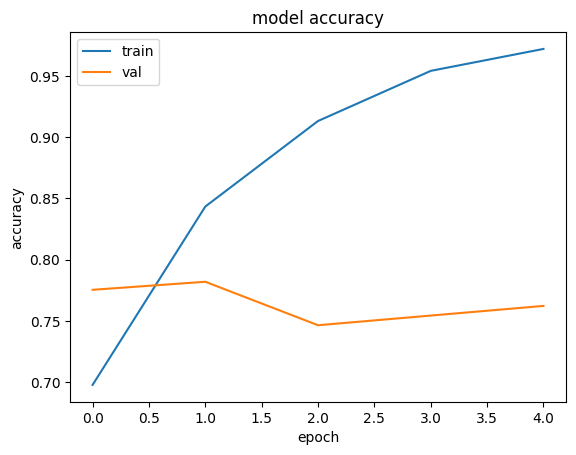

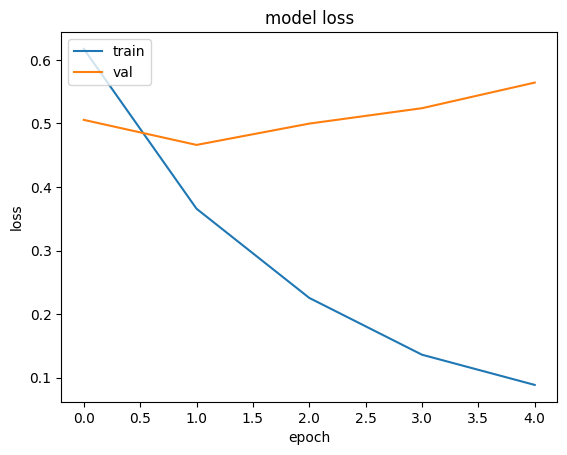

In [93]:
# Accuracy plot

plt.plot(model3_history.history['accuracy'])
plt.plot(model3_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss plot
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


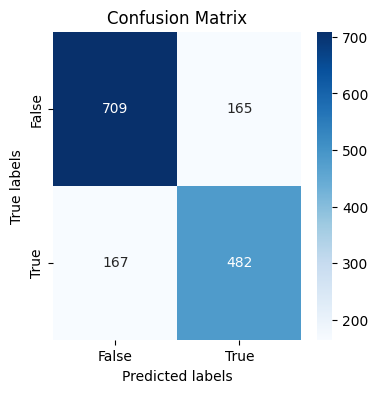

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes for validation data
y_pred = model3.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")  # fmt='d' for integer format
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

# Display the plot
plt.show()


In [95]:
y_pred = model3.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)  


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step
Precision: 0.7449768160741885
Recall: 0.7426810477657936
F1 Score: 0.7438271604938271
ROC-AUC: 0.7769469312055514


In [102]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       874
           1       0.74      0.74      0.74       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



# Submission file

In [ ]:
# Create a DataFrame with the required format
sample_submission = pd.read_csv("./sample_submission.csv")

# Create a DataFrame with the required format using the indices from the sample submission
submission = pd.DataFrame({'id': sample_submission['id'], 'target': pred.flatten()})

# Apply threshold to convert probabilities to binary predictions
submission['target'] = submission['target'].apply(lambda x: 1 if x > 0.5 else 0)

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

# Results and Conclusion

**Conclusion:**

Based on the results, LTSM seems to be performing the best in terms of accuracy, computation and loss.  